In [4]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import random
import math
from scipy import ndimage
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import tensorflow_datasets as tfds
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten,BatchNormalization,Reshape,Conv2DTranspose,UpSampling2D
from tensorflow.keras.layers import Input , Lambda
from keras import backend as k

# Load the dataset:

In [5]:
import glob
data = glob.glob("/kaggle/input/rock-paper-scissors-dataset/Rock-Paper-Scissors/train/paper/*.png")
data += glob.glob("/kaggle/input/rock-paper-scissors-dataset/Rock-Paper-Scissors/train/rock/*.png")
data += glob.glob("/kaggle/input/rock-paper-scissors-dataset/Rock-Paper-Scissors/train/scissors/*.png")
images = [plt.imread(img) for img in data]
print(len(images))

2520


In [6]:
# Map for quick lookup
label_map = {'paper': 0, 'rock': 1, 'scissors': 2}

# Efficient list comprehension
Y = np.array([label_map.get(x.split('/')[-2]) for x in data])

# Shuffle the arrays consistently
images = np.array(images)
images, Y = shuffle(images, Y, random_state=0)

# Dispaly some images:

In [7]:
def display(images,a):
        m,n = 1, int(len(images)/a)
        for i in range(0,len(images),m*n):
            fig = plt.figure(figsize=(15,8))
            for j in range(m*n):
                fig.add_subplot(m,n,j+1)
                plt.imshow(images[i+j])
                plt.axis('off')
            plt.show()

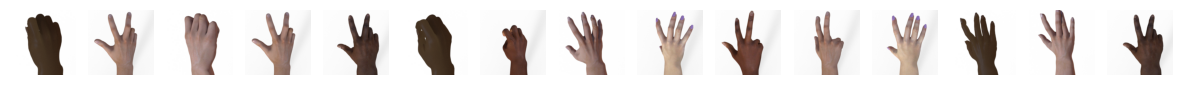

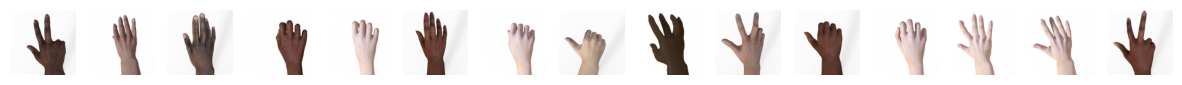

In [8]:
display(images[:30],2)

In [9]:
XTrain,XTest ,YTrain,YTest =train_test_split(images, Y, train_size=0.8)
print(f'Train: {len(XTrain)} images. \n Test: {len(XTest)} images.')

Train: 2016 images. 
 Test: 504 images.


# Erase sections of an image:

In [10]:
def inpaint(I):
  m,n,h = I.shape
  R = np.copy(I)
  i = np.random.randint(0,200)
  j = np.random.randint(70,200)
  mask = np.ones((100,100,h))
  R[i:i+100,j:j+100,:] = mask
  return R

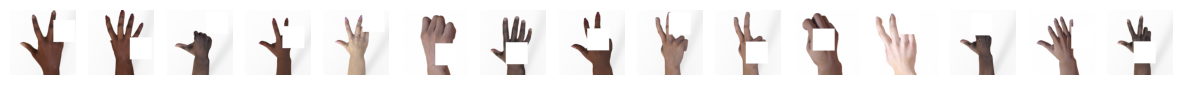

In [11]:
INtrain= [inpaint(img) for img in XTrain]
INtrain = np.array(INtrain)
display(INtrain[:15],1)

# Model:

In [12]:
class AutoEncoder(tf.keras.Model):
    def __init__(self):
        super(AutoEncoder,self).__init__()
        # Encoder:
        self.encoder = Sequential()
        self.encoder.add(Conv2D(64,(3,3),1,activation = 'relu',input_shape=(300,300,4)))
        self.encoder.add(Conv2D(32,(3,3),1,activation = 'relu'))
        self.encoder.add(MaxPooling2D())
        self.encoder.add(BatchNormalization())
        self.encoder.add(Conv2D(32,(3,3),1,activation = 'relu'))
        self.encoder.add(Conv2D(16,(3,3),1,activation = 'relu'))
        self.encoder.add(MaxPooling2D())
        self.encoder.add(Conv2D(16,(3,3),1,activation = 'relu'))
        self.encoder.add(Conv2D(8,(3,3),1,activation = 'relu'))
        self.encoder.add(MaxPooling2D())
        self.encoder.add(BatchNormalization())
        self.encoder.add(Conv2D(8,(3,3),1,activation = 'relu'))
        self.encoder.add(MaxPooling2D())
        self.encoder.add(BatchNormalization())
        self.encoder.add(Flatten())
        self.encoder.add(Dense(100))
        # Decoder:
        self.decoder = Sequential()
        self.decoder.add(Dense(units = 34*34*8,activation = 'relu',input_shape=(100,)))
        self.decoder.add(Reshape(target_shape = (34, 34, 8)))
        self.decoder.add(UpSampling2D((2, 2),interpolation="bilinear"))
        self.decoder.add(BatchNormalization())
        self.decoder.add(Conv2DTranspose(8,(3,3),1,activation = 'relu'))
        self.decoder.add(Conv2DTranspose(16,(3,3),1,activation = 'relu'))
        self.decoder.add(BatchNormalization())
        self.decoder.add(UpSampling2D((2,2),interpolation='bilinear'))
        self.decoder.add(Conv2DTranspose(32,(3,3),1,activation = 'relu'))
        self.decoder.add(Conv2DTranspose(16,(3,3),1,activation = 'relu'))
        self.decoder.add(UpSampling2D((2,2),interpolation='bilinear'))
        self.decoder.add(Conv2DTranspose(16,(3,3),1,activation = 'relu'))
        #self.decoder.add(Conv2DTranspose(8,(3,3),1,activation = 'relu'))
        self.decoder.add(Conv2DTranspose(4,(3,3),1,activation = 'sigmoid'))

    def call(self,x):
        encode = self.encoder(x)
        decode = self.decoder(encode)
        return decode


In [13]:
INpaint =  AutoEncoder()
opt = tf.keras.optimizers.Adam(clipvalue = 0.5)
INpaint.compile(optimizer =opt,loss = tf.losses.MeanSquaredError(),metrics = ['accuracy'])
INpaint.build((1000,300,300,4))
INpaint.summary()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "auto_encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ ?                      │       243,860 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ ?                      │       948,060 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,191,920 (4.55 MB)

 Trainable params: 1,191,776 (4.55 MB)

 Non-trainable params: 144 (576.00 B)

# Training the model:

In [14]:
hist = INpaint.fit(INtrain,XTrain,epochs = 150, validation_split=0.3)

Epoch 1/150


I0000 00:00:1734184120.360815      95 service.cc:145] XLA service 0x7cca90002a50 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1734184120.360891      95 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


 1/45 ━━━━━━━━━━━━━━━━━━━━ 17:38 24s/step - accuracy: 0.0099 - loss: 0.1997

I0000 00:00:1734184138.812015      95 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


45/45 ━━━━━━━━━━━━━━━━━━━━ 49s 561ms/step - accuracy: 0.1220 - loss: 0.1283 - val_accuracy: 0.4894 - val_loss: 0.0352
Epoch 2/150


I0000 00:00:1734184163.605597      94 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'input_reduce_fusion_8', 4 bytes spill stores, 4 bytes spill loads



45/45 ━━━━━━━━━━━━━━━━━━━━ 9s 201ms/step - accuracy: 0.5297 - loss: 0.0349 - val_accuracy: 0.6621 - val_loss: 0.0308
Epoch 3/150
45/45 ━━━━━━━━━━━━━━━━━━━━ 9s 200ms/step - accuracy: 0.7284 - loss: 0.0321 - val_accuracy: 0.7886 - val_loss: 0.0300
Epoch 4/150
45/45 ━━━━━━━━━━━━━━━━━━━━ 9s 202ms/step - accuracy: 0.7749 - loss: 0.0304 - val_accuracy: 0.7787 - val_loss: 0.0277
Epoch 5/150
45/45 ━━━━━━━━━━━━━━━━━━━━ 9s 200ms/step - accuracy: 0.7273 - loss: 0.0298 - val_accuracy: 0.7447 - val_loss: 0.0207
Epoch 6/150
45/45 ━━━━━━━━━━━━━━━━━━━━ 9s 199ms/step - accuracy: 0.7404 - loss: 0.0194 - val_accuracy: 0.7552 - val_loss: 0.0161
Epoch 7/150
45/45 ━━━━━━━━━━━━━━━━━━━━ 9s 201ms/step - accuracy: 0.7485 - loss: 0.0148 - val_accuracy: 0.7599 - val_loss: 0.0135
Epoch 8/150
45/45 ━━━━━━━━━━━━━━━━━━━━ 9s 200ms/step - accuracy: 0.7650 - loss: 0.0116 - val_accuracy: 0.7751 - val_loss: 0.0097
Epoch 9/150
45/45 ━━━━━━━━━━━━━━━━━━━━ 9s 202ms/step - accuracy: 0.7728 - loss: 0.0087 - val_accuracy: 0.7730

# Evaluating the model:

In [15]:
INtest = [inpaint(img) for img in XTest]
INtest = np.array(INtest)
INpaint.evaluate(INtest,XTest)

16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 334ms/step - accuracy: 0.7484 - loss: 0.0023


[0.0023538698442280293, 0.7868673205375671]

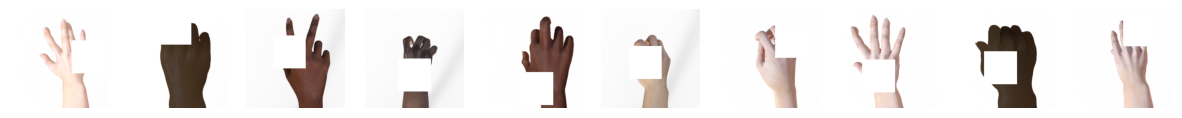

16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 99ms/step


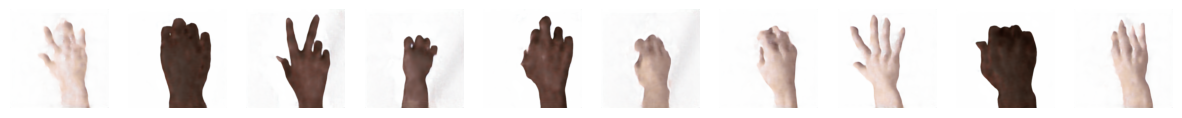

In [16]:
display(INtest[10:20],1)
intest = INpaint.predict(INtest)
display(intest[10:20],1)